# Three-Class Low-Rate DDoS Analysis (Final Corrected)
Displays Test, Augment names correctly and saves all metrics.

In [23]:
import warnings
warnings.filterwarnings('ignore')
import os, glob
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix


In [24]:
def augment_cvae(X, y, n_samples): return X, y
def augment_gan(X, y, n_samples): return X, y


In [25]:
csv_files = glob.glob('CIC-IDS-2017/*.csv')
os.makedirs('split_by_label', exist_ok=True)
for f in csv_files:
    df = pd.read_csv(f)
    df.columns = df.columns.str.strip()
    for lbl, g in df.groupby('Label'):
        safe = lbl.replace('/', '_').replace(' ', '_')
        g.to_csv(f'split_by_label/{safe}.csv', index=False)
df_all = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
df_all.columns = df_all.columns.str.strip()
df = df_all.drop_duplicates().dropna()
print('Cleaned shape:', df.shape)
display(df['Label'].value_counts())


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
benign = df[df['Label']=='BENIGN']
slowloris = df[df['Label']=='DoS slowloris']
slowhttptest = df[df['Label']=='DoS Slowhttptest']
print('Samples - BENIGN:', len(benign), 'Slowloris:', len(slowloris), 'Slowhttptest:', len(slowhttptest))


Samples - BENIGN: 2096134 Slowloris: 5385 Slowhttptest: 5228


In [ ]:
def sample_and_split(n_b, n_sl, n_sht):
    rep=lambda n,arr: n>len(arr)
    df_s=pd.concat([
        benign.sample(n=n_b,random_state=42,replace=rep(n_b,benign)),
        slowloris.sample(n=n_sl,random_state=42,replace=rep(n_sl,slowloris)),
        slowhttptest.sample(n=n_sht,random_state=42,replace=rep(n_sht,slowhttptest))
    ],ignore_index=True)
    df_s=df_s.replace([np.inf,-np.inf],np.nan).dropna()
    X=df_s.drop(columns=['Label'])
    y=df_s['Label'].map({'BENIGN':0,'DoS slowloris':1,'DoS Slowhttptest':2})
    Xs=StandardScaler().fit_transform(X)
    return train_test_split(Xs,y,test_size=0.3,random_state=42,stratify=y)


In [ ]:
tests = {
 'Test1':{'benign':len(slowloris),'slowloris':len(slowloris),'slowhttptest':len(slowloris)},
 'Test2':{'benign':len(benign),'slowloris':len(slowloris),'slowhttptest':len(slowhttptest)},
 'Test3':{'benign':len(slowloris)//2,'slowloris':len(slowloris)//2,'slowhttptest':len(slowhttptest)//2},
 'Test4':{'benign':len(slowloris)*2,'slowloris':len(slowloris),'slowhttptest':len(slowhttptest)}
}
methods=['None','SMOTE','ADASYN','CVAE','GAN']
models={'MLP':MLPClassifier(random_state=42,max_iter=500,early_stopping=True),
 'RandomForest':RandomForestClassifier(random_state=42),
 'LogisticRegression':LogisticRegression(max_iter=1000,random_state=42),
 'XGBoost':XGBClassifier(use_label_encoder=False,eval_metric='logloss',random_state=42)}


In [ ]:

# Evaluate MLP
results = []
for t, sz in tests.items():
    X_tr, X_te, y_tr, y_te = sample_and_split(sz['benign'], sz['slowloris'], sz['slowhttptest'])
    for m in methods:
        cnt_before = np.bincount(y_tr, minlength=3)
        print(f"Test={t}, Aug={m} BEFORE: BENIGN={cnt_before[0]}, Slowloris={cnt_before[1]}, Slowhttptest={cnt_before[2]}")
        if m=='SMOTE':
            X_aug, y_aug = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
        elif m=='ADASYN':
            try:
                X_aug, y_aug = ADASYN(random_state=42).fit_resample(X_tr, y_tr)
            except ValueError:
                X_aug, y_aug = X_tr, y_tr
        elif m=='CVAE':
            X_aug, y_aug = augment_cvae(X_tr, y_tr, sz['benign'])
        elif m=='GAN':
            X_aug, y_aug = augment_gan(X_tr, y_tr, sz['benign'])
        else:
            X_aug, y_aug = X_tr, y_tr
        cnt_after = np.bincount(y_aug, minlength=3)
        print(f"Test={t}, Aug={m} AFTER: BENIGN={cnt_after[0]}, Slowloris={cnt_after[1]}, Slowhttptest={cnt_after[2]}")
        clf = models['MLP']
        clf.fit(X_aug, y_aug)
        y_pred = clf.predict(X_te)
        y_proba = clf.predict_proba(X_te)
        acc = clf.score(X_te, y_te)
        prec = precision_score(y_te, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_te, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_te, y_pred, average='macro', zero_division=0)
        roc = roc_auc_score(y_te, y_proba, multi_class='ovo')
        attack_rec = (recall_score(y_te, y_pred, labels=[1], average='macro') + recall_score(y_te, y_pred, labels=[2], average='macro'))/2
        cm = confusion_matrix(y_te, y_pred)
        print("Confusion Matrix:\n", cm)
        print("Classification Report:\n", classification_report(y_te, y_pred, digits=4))
        print(f"Attack Recall avg: {attack_rec:.4f}\n")
        results.append({'Test': t, 'Augmentation': m, 'Model': 'MLP',
                         'Before_BENIGN': cnt_before[0], 'Before_Slowloris': cnt_before[1], 'Before_Slowhttptest': cnt_before[2],
                         'After_BENIGN': cnt_after[0], 'After_Slowloris': cnt_after[1], 'After_Slowhttptest': cnt_after[2],
                         'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1, 'ROC-AUC': roc, 'Attack_Recall_Avg': attack_rec})
df = pd.DataFrame(results)
display(df)
csv_name = "mlp_threeclass_results.csv"
df.to_csv(csv_name, index=False)
print(f"Saved to {csv_name}")


Test=Test1, Aug=None BEFORE: BENIGN=3767, Slowloris=3769, Slowhttptest=3770
Test=Test1, Aug=None AFTER: BENIGN=3767, Slowloris=3769, Slowhttptest=3770
Confusion Matrix:
 [[1605    4    6]
 [   5 1597   14]
 [   4    4 1607]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9944    0.9938    0.9941      1615
           1     0.9950    0.9882    0.9916      1616
           2     0.9877    0.9950    0.9914      1615

    accuracy                         0.9924      4846
   macro avg     0.9924    0.9924    0.9924      4846
weighted avg     0.9924    0.9924    0.9924      4846

Attack Recall avg: 0.9916

Test=Test1, Aug=SMOTE BEFORE: BENIGN=3767, Slowloris=3769, Slowhttptest=3770
Test=Test1, Aug=SMOTE AFTER: BENIGN=3770, Slowloris=3770, Slowhttptest=3770
Confusion Matrix:
 [[1609    3    3]
 [   5 1599   12]
 [   4    4 1607]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9944    0.9963    

,Test,Augmentation,Model,Before_BENIGN,Before_Slowloris,Before_Slowhttptest,After_BENIGN,After_Slowloris,After_Slowhttptest,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Attack_Recall_Avg
0,Test1,None,MLP,3767,3769,3770,3767,3769,3770,0.992365,0.992382,0.992366,0.992366,0.998962,0.991645
1,Test1,SMOTE,MLP,3767,3769,3770,3770,3770,3770,0.993603,0.993610,0.993604,0.993602,0.999053,0.992263
2,Test1,ADASYN,MLP,3767,3769,3770,3767,3769,3770,0.992365,0.992382,0.992366,0.992366,0.998962,0.991645
3,Test1,CVAE,MLP,3767,3769,3770,3767,3769,3770,0.992365,0.992382,0.992366,0.992366,0.998962,0.991645
4,Test1,GAN,MLP,3767,3769,3770,3767,3769,3770,0.992365,0.992382,0.992366,0.992366,0.998962,0.991645
5,Test2,None,MLP,1466540,3769,3660,1466540,3769,3660,0.999601,0.957083,0.989852,0.972614,0.997493,0.984940
6,Test2,SMOTE,MLP,1466540,3769,3660,1466540,1466540,1466540,0.999324,0.922128,0.995396,0.956400,0.999117,0.993417
7,Test2,ADASYN,MLP,1466540,3769,3660,1466540,1466573,1466557,0.995360,0.711856,0.985582,0.803125,0.996504,0.980656
8,Test2,CVAE,MLP,1466540,3769,3660,1466540,3769,3660,0.999601,0.957083,0.989852,0.972614,0.997493,0.984940
9,Test2,GAN,MLP,1466540,3769,3660,1466540,3769,3660,0.999601,0.957083,0.989852,0.972614,0.997493,0.984940


Saved to mlp_threeclass_results.csv


In [ ]:

# Evaluate RandomForest
results = []
for t, sz in tests.items():
    X_tr, X_te, y_tr, y_te = sample_and_split(sz['benign'], sz['slowloris'], sz['slowhttptest'])
    for m in methods:
        cnt_before = np.bincount(y_tr, minlength=3)
        print(f"Test={t}, Aug={m} BEFORE: BENIGN={cnt_before[0]}, Slowloris={cnt_before[1]}, Slowhttptest={cnt_before[2]}")
        if m=='SMOTE':
            X_aug, y_aug = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
        elif m=='ADASYN':
            try:
                X_aug, y_aug = ADASYN(random_state=42).fit_resample(X_tr, y_tr)
            except ValueError:
                X_aug, y_aug = X_tr, y_tr
        elif m=='CVAE':
            X_aug, y_aug = augment_cvae(X_tr, y_tr, sz['benign'])
        elif m=='GAN':
            X_aug, y_aug = augment_gan(X_tr, y_tr, sz['benign'])
        else:
            X_aug, y_aug = X_tr, y_tr
        cnt_after = np.bincount(y_aug, minlength=3)
        print(f"Test={t}, Aug={m} AFTER: BENIGN={cnt_after[0]}, Slowloris={cnt_after[1]}, Slowhttptest={cnt_after[2]}")
        clf = models['RandomForest']
        clf.fit(X_aug, y_aug)
        y_pred = clf.predict(X_te)
        y_proba = clf.predict_proba(X_te)
        acc = clf.score(X_te, y_te)
        prec = precision_score(y_te, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_te, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_te, y_pred, average='macro', zero_division=0)
        roc = roc_auc_score(y_te, y_proba, multi_class='ovo')
        attack_rec = (recall_score(y_te, y_pred, labels=[1], average='macro') + recall_score(y_te, y_pred, labels=[2], average='macro'))/2
        cm = confusion_matrix(y_te, y_pred)
        print("Confusion Matrix:\n", cm)
        print("Classification Report:\n", classification_report(y_te, y_pred, digits=4))
        print(f"Attack Recall avg: {attack_rec:.4f}\n")
        results.append({'Test': t, 'Augmentation': m, 'Model': 'RandomForest',
                         'Before_BENIGN': cnt_before[0], 'Before_Slowloris': cnt_before[1], 'Before_Slowhttptest': cnt_before[2],
                         'After_BENIGN': cnt_after[0], 'After_Slowloris': cnt_after[1], 'After_Slowhttptest': cnt_after[2],
                         'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1, 'ROC-AUC': roc, 'Attack_Recall_Avg': attack_rec})
df = pd.DataFrame(results)
display(df)
csv_name = "randomforest_threeclass_results.csv"
df.to_csv(csv_name, index=False)
print(f"Saved to {csv_name}")


Test=Test1, Aug=None BEFORE: BENIGN=3767, Slowloris=3769, Slowhttptest=3770
Test=Test1, Aug=None AFTER: BENIGN=3767, Slowloris=3769, Slowhttptest=3770
Confusion Matrix:
 [[1612    1    2]
 [   4 1609    3]
 [   0    3 1612]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9975    0.9981    0.9978      1615
           1     0.9975    0.9957    0.9966      1616
           2     0.9969    0.9981    0.9975      1615

    accuracy                         0.9973      4846
   macro avg     0.9973    0.9973    0.9973      4846
weighted avg     0.9973    0.9973    0.9973      4846

Attack Recall avg: 0.9969

Test=Test1, Aug=SMOTE BEFORE: BENIGN=3767, Slowloris=3769, Slowhttptest=3770
Test=Test1, Aug=SMOTE AFTER: BENIGN=3770, Slowloris=3770, Slowhttptest=3770
Confusion Matrix:
 [[1612    1    2]
 [   4 1609    3]
 [   0    3 1612]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9975    0.9981    

,Test,Augmentation,Model,Before_BENIGN,Before_Slowloris,Before_Slowhttptest,After_BENIGN,After_Slowloris,After_Slowhttptest,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Attack_Recall_Avg
0,Test1,None,RandomForest,3767,3769,3770,3767,3769,3770,0.997317,0.997318,0.997318,0.997317,0.999775,0.996905
1,Test1,SMOTE,RandomForest,3767,3769,3770,3770,3770,3770,0.997317,0.997318,0.997318,0.997317,0.999776,0.996905
2,Test1,ADASYN,RandomForest,3767,3769,3770,3767,3769,3770,0.997317,0.997318,0.997318,0.997317,0.999775,0.996905
3,Test1,CVAE,RandomForest,3767,3769,3770,3767,3769,3770,0.997317,0.997318,0.997318,0.997317,0.999775,0.996905
4,Test1,GAN,RandomForest,3767,3769,3770,3767,3769,3770,0.997317,0.997318,0.997318,0.997317,0.999775,0.996905
5,Test2,None,RandomForest,1466540,3769,3660,1466540,3769,3660,0.999940,0.995978,0.994112,0.995043,0.998674,0.991176
6,Test2,SMOTE,RandomForest,1466540,3769,3660,1466540,1466540,1466540,0.999946,0.995364,0.995380,0.995372,0.999329,0.993079
7,Test2,ADASYN,RandomForest,1466540,3769,3660,1466540,1466573,1466557,0.999788,0.975528,0.975582,0.974897,0.999305,0.963386
8,Test2,CVAE,RandomForest,1466540,3769,3660,1466540,3769,3660,0.999940,0.995978,0.994112,0.995043,0.998674,0.991176
9,Test2,GAN,RandomForest,1466540,3769,3660,1466540,3769,3660,0.999940,0.995978,0.994112,0.995043,0.998674,0.991176


Saved to randomforest_threeclass_results.csv


In [ ]:

# Evaluate LogisticRegression
results = []
for t, sz in tests.items():
    X_tr, X_te, y_tr, y_te = sample_and_split(sz['benign'], sz['slowloris'], sz['slowhttptest'])
    for m in methods:
        cnt_before = np.bincount(y_tr, minlength=3)
        print(f"Test={t}, Aug={m} BEFORE: BENIGN={cnt_before[0]}, Slowloris={cnt_before[1]}, Slowhttptest={cnt_before[2]}")
        if m=='SMOTE':
            X_aug, y_aug = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
        elif m=='ADASYN':
            try:
                X_aug, y_aug = ADASYN(random_state=42).fit_resample(X_tr, y_tr)
            except ValueError:
                X_aug, y_aug = X_tr, y_tr
        elif m=='CVAE':
            X_aug, y_aug = augment_cvae(X_tr, y_tr, sz['benign'])
        elif m=='GAN':
            X_aug, y_aug = augment_gan(X_tr, y_tr, sz['benign'])
        else:
            X_aug, y_aug = X_tr, y_tr
        cnt_after = np.bincount(y_aug, minlength=3)
        print(f"Test={t}, Aug={m} AFTER: BENIGN={cnt_after[0]}, Slowloris={cnt_after[1]}, Slowhttptest={cnt_after[2]}")
        clf = models['LogisticRegression']
        clf.fit(X_aug, y_aug)
        y_pred = clf.predict(X_te)
        y_proba = clf.predict_proba(X_te)
        acc = clf.score(X_te, y_te)
        prec = precision_score(y_te, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_te, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_te, y_pred, average='macro', zero_division=0)
        roc = roc_auc_score(y_te, y_proba, multi_class='ovo')
        attack_rec = (recall_score(y_te, y_pred, labels=[1], average='macro') + recall_score(y_te, y_pred, labels=[2], average='macro'))/2
        cm = confusion_matrix(y_te, y_pred)
        print("Confusion Matrix:\n", cm)
        print("Classification Report:\n", classification_report(y_te, y_pred, digits=4))
        print(f"Attack Recall avg: {attack_rec:.4f}\n")
        results.append({'Test': t, 'Augmentation': m, 'Model': 'LogisticRegression',
                         'Before_BENIGN': cnt_before[0], 'Before_Slowloris': cnt_before[1], 'Before_Slowhttptest': cnt_before[2],
                         'After_BENIGN': cnt_after[0], 'After_Slowloris': cnt_after[1], 'After_Slowhttptest': cnt_after[2],
                         'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1, 'ROC-AUC': roc, 'Attack_Recall_Avg': attack_rec})
df = pd.DataFrame(results)
display(df)
csv_name = "logisticregression_threeclass_results.csv"
df.to_csv(csv_name, index=False)
print(f"Saved to {csv_name}")


Test=Test1, Aug=None BEFORE: BENIGN=3767, Slowloris=3769, Slowhttptest=3770
Test=Test1, Aug=None AFTER: BENIGN=3767, Slowloris=3769, Slowhttptest=3770
Confusion Matrix:
 [[1578   19   18]
 [   4 1576   36]
 [   6   38 1571]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9937    0.9771    0.9853      1615
           1     0.9651    0.9752    0.9701      1616
           2     0.9668    0.9728    0.9698      1615

    accuracy                         0.9750      4846
   macro avg     0.9752    0.9750    0.9751      4846
weighted avg     0.9752    0.9750    0.9751      4846

Attack Recall avg: 0.9740

Test=Test1, Aug=SMOTE BEFORE: BENIGN=3767, Slowloris=3769, Slowhttptest=3770
Test=Test1, Aug=SMOTE AFTER: BENIGN=3770, Slowloris=3770, Slowhttptest=3770
Confusion Matrix:
 [[1579   17   19]
 [   4 1576   36]
 [   6   38 1571]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9937    0.9777    

,Test,Augmentation,Model,Before_BENIGN,Before_Slowloris,Before_Slowhttptest,After_BENIGN,After_Slowloris,After_Slowhttptest,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Attack_Recall_Avg
0,Test1,None,LogisticRegression,3767,3769,3770,3767,3769,3770,0.975031,0.975189,0.975031,0.975075,0.997516,0.974001
1,Test1,SMOTE,LogisticRegression,3767,3769,3770,3770,3770,3770,0.975237,0.975387,0.975237,0.975280,0.997505,0.974001
2,Test1,ADASYN,LogisticRegression,3767,3769,3770,3767,3769,3770,0.975031,0.975189,0.975031,0.975075,0.997516,0.974001
3,Test1,CVAE,LogisticRegression,3767,3769,3770,3767,3769,3770,0.975031,0.975189,0.975031,0.975075,0.997516,0.974001
4,Test1,GAN,LogisticRegression,3767,3769,3770,3767,3769,3770,0.975031,0.975189,0.975031,0.975075,0.997516,0.974001
5,Test2,None,LogisticRegression,1466540,3769,3660,1466540,3769,3660,0.998007,0.896516,0.793043,0.835605,0.984247,0.689776
6,Test2,SMOTE,LogisticRegression,1466540,3769,3660,1466540,1466540,1466540,0.987109,0.543001,0.986933,0.642801,0.998414,0.986844
7,Test2,ADASYN,LogisticRegression,1466540,3769,3660,1466540,1466573,1466557,0.947084,0.397963,0.739545,0.432156,0.829975,0.634983
8,Test2,CVAE,LogisticRegression,1466540,3769,3660,1466540,3769,3660,0.998007,0.896516,0.793043,0.835605,0.984247,0.689776
9,Test2,GAN,LogisticRegression,1466540,3769,3660,1466540,3769,3660,0.998007,0.896516,0.793043,0.835605,0.984247,0.689776


Saved to logisticregression_threeclass_results.csv


In [ ]:

# Evaluate XGBoost
results = []
for t, sz in tests.items():
    X_tr, X_te, y_tr, y_te = sample_and_split(sz['benign'], sz['slowloris'], sz['slowhttptest'])
    for m in methods:
        cnt_before = np.bincount(y_tr, minlength=3)
        print(f"Test={t}, Aug={m} BEFORE: BENIGN={cnt_before[0]}, Slowloris={cnt_before[1]}, Slowhttptest={cnt_before[2]}")
        if m=='SMOTE':
            X_aug, y_aug = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
        elif m=='ADASYN':
            try:
                X_aug, y_aug = ADASYN(random_state=42).fit_resample(X_tr, y_tr)
            except ValueError:
                X_aug, y_aug = X_tr, y_tr
        elif m=='CVAE':
            X_aug, y_aug = augment_cvae(X_tr, y_tr, sz['benign'])
        elif m=='GAN':
            X_aug, y_aug = augment_gan(X_tr, y_tr, sz['benign'])
        else:
            X_aug, y_aug = X_tr, y_tr
        cnt_after = np.bincount(y_aug, minlength=3)
        print(f"Test={t}, Aug={m} AFTER: BENIGN={cnt_after[0]}, Slowloris={cnt_after[1]}, Slowhttptest={cnt_after[2]}")
        clf = models['XGBoost']
        clf.fit(X_aug, y_aug)
        y_pred = clf.predict(X_te)
        y_proba = clf.predict_proba(X_te)
        acc = clf.score(X_te, y_te)
        prec = precision_score(y_te, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_te, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_te, y_pred, average='macro', zero_division=0)
        roc = roc_auc_score(y_te, y_proba, multi_class='ovo')
        attack_rec = (recall_score(y_te, y_pred, labels=[1], average='macro') + recall_score(y_te, y_pred, labels=[2], average='macro'))/2
        cm = confusion_matrix(y_te, y_pred)
        print("Confusion Matrix:\n", cm)
        print("Classification Report:\n", classification_report(y_te, y_pred, digits=4))
        print(f"Attack Recall avg: {attack_rec:.4f}\n")
        results.append({'Test': t, 'Augmentation': m, 'Model': 'XGBoost',
                         'Before_BENIGN': cnt_before[0], 'Before_Slowloris': cnt_before[1], 'Before_Slowhttptest': cnt_before[2],
                         'After_BENIGN': cnt_after[0], 'After_Slowloris': cnt_after[1], 'After_Slowhttptest': cnt_after[2],
                         'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1, 'ROC-AUC': roc, 'Attack_Recall_Avg': attack_rec})
df = pd.DataFrame(results)
display(df)
csv_name = "xgboost_threeclass_results.csv"
df.to_csv(csv_name, index=False)
print(f"Saved to {csv_name}")


Test=Test1, Aug=None BEFORE: BENIGN=3767, Slowloris=3769, Slowhttptest=3770
Test=Test1, Aug=None AFTER: BENIGN=3767, Slowloris=3769, Slowhttptest=3770
Confusion Matrix:
 [[1614    0    1]
 [   2 1608    6]
 [   0    3 1612]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9988    0.9994    0.9991      1615
           1     0.9981    0.9950    0.9966      1616
           2     0.9957    0.9981    0.9969      1615

    accuracy                         0.9975      4846
   macro avg     0.9975    0.9975    0.9975      4846
weighted avg     0.9975    0.9975    0.9975      4846

Attack Recall avg: 0.9966

Test=Test1, Aug=SMOTE BEFORE: BENIGN=3767, Slowloris=3769, Slowhttptest=3770
Test=Test1, Aug=SMOTE AFTER: BENIGN=3770, Slowloris=3770, Slowhttptest=3770
Confusion Matrix:
 [[1614    0    1]
 [   2 1609    5]
 [   0    2 1613]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9988    0.9994    

,Test,Augmentation,Model,Before_BENIGN,Before_Slowloris,Before_Slowhttptest,After_BENIGN,After_Slowloris,After_Slowhttptest,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Attack_Recall_Avg
0,Test1,None,XGBoost,3767,3769,3770,3767,3769,3770,0.997524,0.997526,0.997524,0.997524,0.999848,0.996596
1,Test1,SMOTE,XGBoost,3767,3769,3770,3770,3770,3770,0.997936,0.997938,0.997937,0.997936,0.999790,0.997215
2,Test1,ADASYN,XGBoost,3767,3769,3770,3767,3769,3770,0.997524,0.997526,0.997524,0.997524,0.999848,0.996596
3,Test1,CVAE,XGBoost,3767,3769,3770,3767,3769,3770,0.997524,0.997526,0.997524,0.997524,0.999848,0.996596
4,Test1,GAN,XGBoost,3767,3769,3770,3767,3769,3770,0.997524,0.997526,0.997524,0.997524,0.999848,0.996596
5,Test2,None,XGBoost,1466540,3769,3660,1466540,3769,3660,0.999949,0.995572,0.995606,0.995586,0.999764,0.993417
6,Test2,SMOTE,XGBoost,1466540,3769,3660,1466540,1466540,1466540,0.999929,0.992249,0.994364,0.993296,0.999851,0.991561
7,Test2,ADASYN,XGBoost,1466540,3769,3660,1466540,1466573,1466557,0.999661,0.960216,0.959916,0.958135,0.999033,0.939890
8,Test2,CVAE,XGBoost,1466540,3769,3660,1466540,3769,3660,0.999949,0.995572,0.995606,0.995586,0.999764,0.993417
9,Test2,GAN,XGBoost,1466540,3769,3660,1466540,3769,3660,0.999949,0.995572,0.995606,0.995586,0.999764,0.993417


Saved to xgboost_threeclass_results.csv


## Summary
Results saved to CSV files.

,Test,Augmentation,Model,Before_BENIGN,Before_Slowloris,Before_Slowhttptest,After_BENIGN,After_Slowloris,After_Slowhttptest,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Attack_Recall_Avg
0,Test1,None,MLP,3767,3769,3770,3767,3769,3770,0.992365,0.992382,0.992366,0.992366,0.998962,0.991645
1,Test1,SMOTE,MLP,3767,3769,3770,3770,3770,3770,0.993603,0.993610,0.993604,0.993602,0.999053,0.992263
2,Test1,ADASYN,MLP,3767,3769,3770,3767,3769,3770,0.992365,0.992382,0.992366,0.992366,0.998962,0.991645
3,Test1,CVAE,MLP,3767,3769,3770,3767,3769,3770,0.992365,0.992382,0.992366,0.992366,0.998962,0.991645
4,Test1,GAN,MLP,3767,3769,3770,3767,3769,3770,0.992365,0.992382,0.992366,0.992366,0.998962,0.991645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Test4,None,XGBoost,7537,3769,3660,7537,3769,3660,0.997038,0.996756,0.996140,0.996446,0.999645,0.994364
76,Test4,SMOTE,XGBoost,7537,3769,3660,7537,7537,7537,0.996882,0.996544,0.995933,0.996237,0.999625,0.994055
77,Test4,ADASYN,XGBoost,7537,3769,3660,7537,7529,7533,0.989710,0.987067,0.986445,0.986594,0.999453,0.979822
78,Test4,CVAE,XGBoost,7537,3769,3660,7537,3769,3660,0.997038,0.996756,0.996140,0.996446,0.999645,0.994364


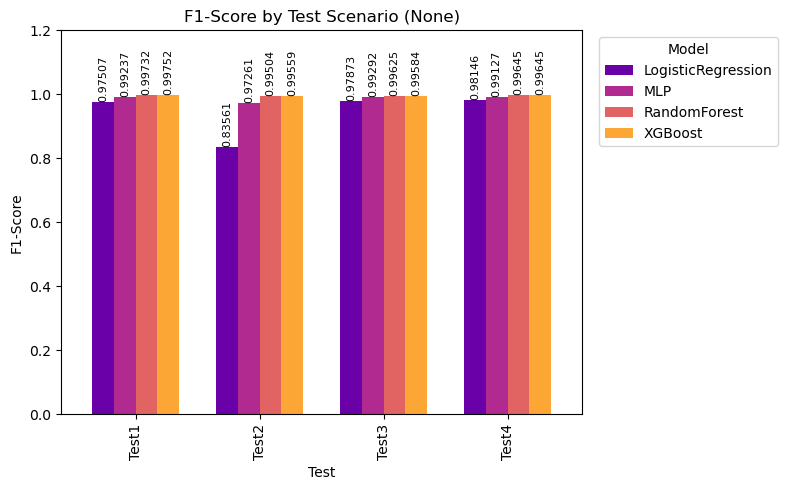

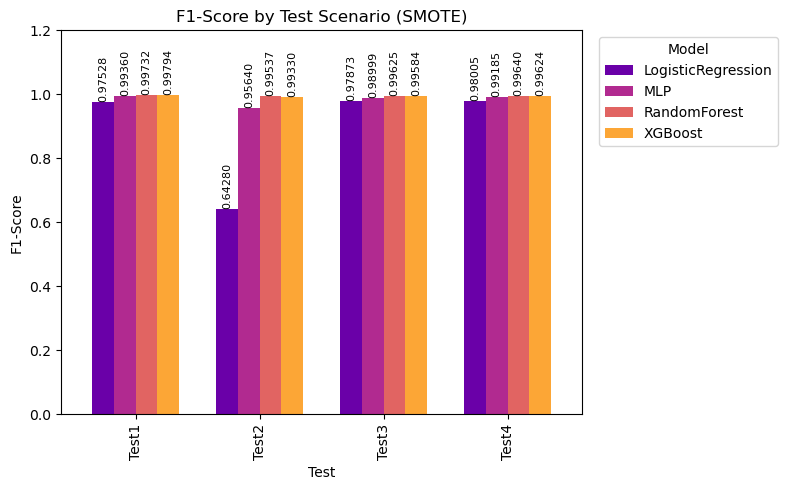

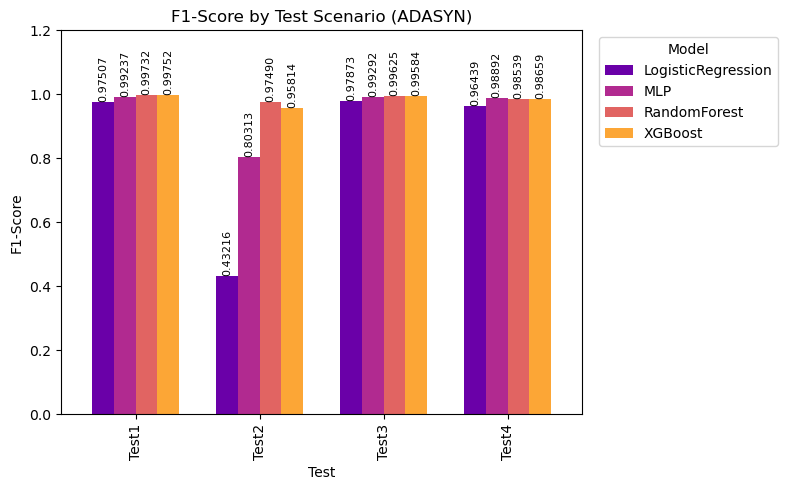

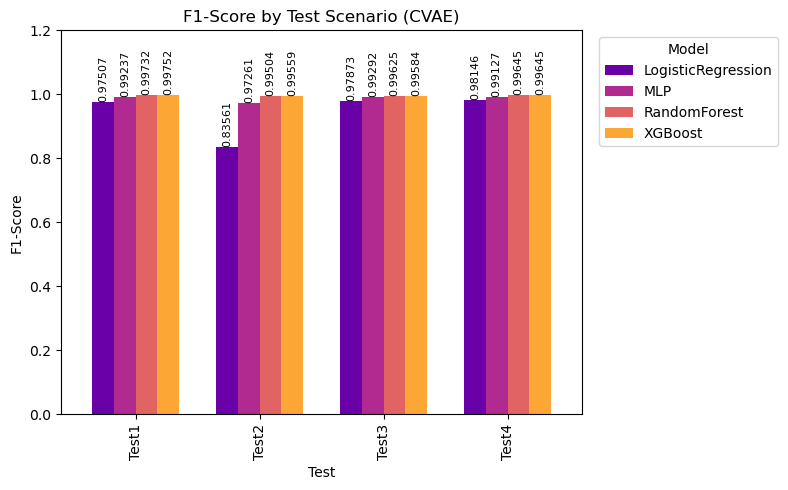

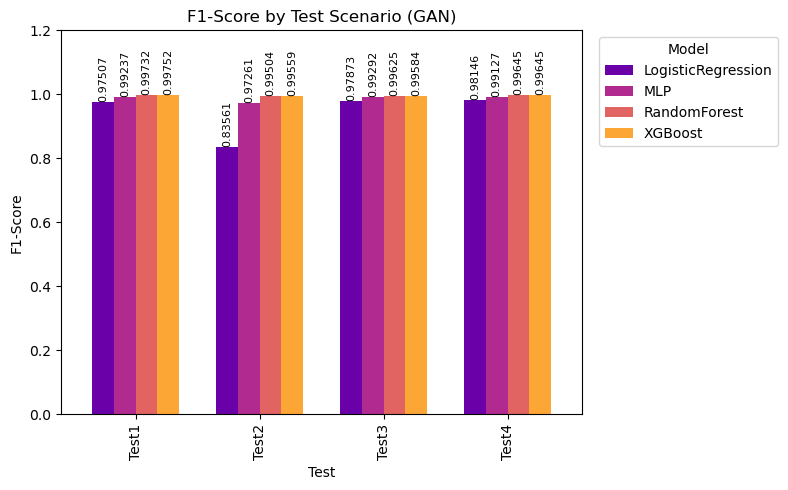

In [ ]:
# Summary: Combine all results and visualize
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load individual model results without treating "None" as NA
df_mlp = pd.read_csv('mlp_threeclass_results.csv', keep_default_na=False)
df_rf  = pd.read_csv('randomforest_threeclass_results.csv', keep_default_na=False)
df_lr  = pd.read_csv('logisticregression_threeclass_results.csv', keep_default_na=False)
df_xgb = pd.read_csv('xgboost_threeclass_results.csv', keep_default_na=False)

# Combine and restore 'None' entries
df_all = pd.concat([df_mlp, df_rf, df_lr, df_xgb], ignore_index=True)
df_all['Augmentation'] = df_all['Augmentation'].replace('', 'None')
df_all.to_csv('threeclass_combined_results.csv', index=False)
display(df_all)

# Bar charts: F1-Score by Test scenario for each augmentation method
test_order = ['Test1','Test2','Test3','Test4']
cmap = plt.get_cmap('plasma')

for aug in ['None','SMOTE','ADASYN','CVAE','GAN']:
    df_aug = df_all[df_all['Augmentation'] == aug]
    if df_aug.empty:
        continue
    df_plot = df_aug.pivot(index='Test', columns='Model', values='F1-Score').reindex(test_order)

    colors = [cmap(x) for x in np.linspace(0.2, 0.8, df_plot.shape[1])]
    ax = df_plot.plot(kind='bar', figsize=(8, 5), color=colors, width=0.7)
    plt.title(f'F1-Score by Test Scenario ({aug})')
    plt.ylabel('F1-Score')
    plt.ylim(0, 1.2)
    ax.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')

    # Annotate
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.5f}',
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', rotation='vertical', fontsize=8)

    plt.tight_layout()
    plt.show()